# HELP - ELAIS-N1 Master List Creation

This notebook presents the creation of the HELP master list on the ELAIS-N1 field.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
11b73d3 (Wed Mar 8 18:03:54 2017 +0000)


## Data

- Isaac Newton Telescope / Wide Field Camera (INT/WFC): The catalogue was provided by Eduardo. The catalogue is described in [this paper](https://academic.oup.com/mnras/article/416/2/927/1055929/Wide-field-optical-imaging-on-ELAIS-N1-ELAIS-N2).
- UKIRT Infrared Deep Sky Survey / Deep Extragalactic Survey (UKIDSS/DXS): The catalogue was provided by Eduardo from an extraction made by Mattia. The catalogue is quite different from what can be extracted from the UKIDSS database (FIXME: Mattia to explain why). The descriptions of the columns of the DXS table in the UKIDSS database is available there: http://horus.roe.ac.uk/wsa/www/WSA_TABLE_dxsSourceSchema.html.
- Spitzer datafusion SERVS and SWIRE: the Spitzer catalogues produced by the datafusion team are available in the HELP virtual observatory server. They are described there: http://vohedamtest.lam.fr/browse/df_spitzer/q.
- SpARCS (Spitzer Adaptation of the Red-sequence Cluster Survey) catalogue. This catalogue comes from `dmu0_SpARCS`.

Additional catalogue used:

- Extraction of Gaia DR1 on the ELAIS-N1 field from HeDaM used for astrometry correction.

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from astropy.table import Column, Table
from astropy.coordinates import SkyCoord
import numpy as np
import seaborn as sns

from herschelhelp_internal.utils import (aperture_correction, astrometric_correction, 
                                         flux_to_mag, mag_to_flux, ebv, gen_help_id)
from herschelhelp_internal.masterlist import (remove_duplicates, merge_catalogues, 
                                              nb_astcor_diag_plot)
from herschelhelp_internal.flagging import gaia_flag_column

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## I - Pristine catalogues preparation

### INT/WFC

We keep:
- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in apertude 4 ($1.2 * \sqrt{2}$ arcsec = 1.7 arcsec).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

The catalogue has been cross-matched with SDSS-DR9 catalogue to check that the magnitudes are AB ones.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [3]:
wfc = Table.read("data/en1_intwfc_v2.1_HELP_coverage.fits")[
    'id', 'ra', 'decl', 'pstar',     
    'umag4', 'uemag4', 'ukronmag', 'uekronmag',
    'gmag4', 'gemag4', 'gkronmag', 'gekronmag',
    'rmag4', 'remag4', 'rkronmag', 'rekronmag',
    'imag4', 'iemag4', 'ikronmag', 'iekronmag',
    'zmag4', 'zemag4', 'zkronmag', 'zekronmag']
wfc = Table(wfc.as_array(), names=[
    'wfc_id', 'wfc_ra', 'wfc_dec', 'wfc_stellarity',
    'm_app_wfc_u', 'merr_app_wfc_u', 'm_wfc_u', 'merr_wfc_u',
    'm_app_wfc_g', 'merr_app_wfc_g', 'm_wfc_g', 'merr_wfc_g',
    'm_app_wfc_r', 'merr_app_wfc_r', 'm_wfc_r', 'merr_wfc_r',
    'm_app_wfc_i', 'merr_app_wfc_i', 'm_wfc_i', 'merr_wfc_i',
    'm_app_wfc_z', 'merr_app_wfc_z', 'm_wfc_z', 'merr_wfc_z',
])
wfc_epoch = 2011

# Adding flux and band-flag columns
for col in wfc.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(wfc[col]), np.array(wfc[errcol]))

        # Fluxes are added in µJy
        wfc.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        wfc.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        wfc.add_column(Column(np.zeros(len(wfc), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [4]:
wfc[:10].show_in_notebook()

idx,wfc_id,wfc_ra,wfc_dec,wfc_stellarity,m_app_wfc_u,merr_app_wfc_u,m_wfc_u,merr_wfc_u,m_app_wfc_g,merr_app_wfc_g,m_wfc_g,merr_wfc_g,m_app_wfc_r,merr_app_wfc_r,m_wfc_r,merr_wfc_r,m_app_wfc_i,merr_app_wfc_i,m_wfc_i,merr_wfc_i,m_app_wfc_z,merr_app_wfc_z,m_wfc_z,merr_wfc_z,f_app_wfc_u,ferr_app_wfc_u,flag_app_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_app_wfc_g,ferr_app_wfc_g,flag_app_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_app_wfc_r,ferr_app_wfc_r,flag_app_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_app_wfc_i,ferr_app_wfc_i,flag_app_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_app_wfc_z,ferr_app_wfc_z,flag_app_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z
0,189636200346,240.538272005,55.885030264,0.000171437,23.875,0.235,23.997,0.488,22.656,0.045,22.623,0.052,21.355,0.037,21.453,0.037,21.057,0.05,21.187,0.046,20.648,0.084,20.799,0.088,1.02329,0.221484,False,0.914534,0.411051,False,3.14485,0.130343,False,3.24191,0.155267,False,10.4232,0.355204,False,9.52358,0.324547,False,13.7151,0.631606,False,12.1675,0.515506,False,19.9894,1.54652,False,17.394,1.40980223659,False
1,189636201299,240.616100794,55.770734294,0.00306748,nan,nan,nan,nan,24.079,0.22,23.528,0.2,23.23,0.18,23.004,0.204,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,0.848007,0.17183,False,1.40864,0.259481,False,1.85353,0.30729,False,2.28244,0.42885,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
2,189636201298,240.703609131,55.770877382,0.486486,nan,nan,nan,nan,23.967,0.199,23.985,0.256,23.534,0.238,23.476,0.339,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,0.940157,0.172317,False,0.924697,0.218029,False,1.40088,0.30708,False,1.47775,0.461398,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
3,189636201297,240.584109531,55.770868417,0.00306748,nan,nan,nan,nan,nan,nan,nan,nan,22.724,0.114,22.623,0.183,22.442,0.15,22.371,0.273,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,2.95392,0.310156,False,3.24191,0.546421,False,3.83001,0.529136,False,4.08884,1.02811,False,nan,nan,False,nan,nan,False
4,189636201296,240.641668965,55.771558572,9.52581e-06,nan,nan,nan,nan,22.192,0.049,22.195,0.057,21.069,0.031,21.128,0.032,20.517,0.038,20.476,0.042,20.227,0.064,20.211,0.076,nan,nan,False,nan,nan,False,4.8217,0.217606,False,4.8084,0.252436,False,13.5644,0.387291,False,12.8469,0.378639,False,22.5528,0.789331,False,23.4207,0.905993,False,29.4578,1.73642,False,29.8951,2.09261364216,False
5,189636201295,240.487648046,55.77129696,9.52581e-06,nan,nan,nan,nan,23.386,0.12,23.341,0.193,22.299,0.079,22.372,0.082,21.476,0.067,21.526,0.07,21.323,0.125,21.384,0.137,nan,nan,False,nan,nan,False,1.60546,0.177442,False,1.6734,0.297463,False,4.36918,0.317909,False,4.08507,0.308524,False,9.32395,0.575374,False,8.90431,0.574082,False,10.7349,1.23591,False,10.1484,1.28054794823,False
6,189636201294,240.583398397,55.771571316,5.29221e-07,22.491,0.075,22.642,0.069,21.809,0.041,21.788,0.05,21.206,0.033,21.17,0.043,20.942,0.047,20.89,0.058,20.895,0.091,20.626,0.131,3.661,0.252893,False,3.18566,0.202453,False,6.8612,0.259095,False,6.9952,0.322141,False,11.9564,0.363404,False,12.3595,0.48949,False,15.2475,0.660045,False,15.9956,0.854483,False,15.9221,1.33449,False,20.3986,2.46119958865,False
7,189636201293,240.630510173,55.771586358,0.999657,nan,nan,nan,nan,23.753,0.165,23.873,0.141,23.248,0.183,23.313,0.116,22.989,0.245,23.259,0.216,nan,nan,nan,nan,nan,nan,False,nan,nan,False,1.14498,0.174004,False,1.02518,0.133136,False,1.82306,0.307275,False,1.71712,0.183457,False,2.31419,0.522206,False,1.80468,0.359029,False,nan,nan,False,nan,nan,False
8,189636201292,240.412675797,55.771168243,9.52581e-06,nan,nan,nan,nan,22.929,0.082,22.749,0.104,22.073,0.065,21.864,0.099,21.955,0.086,22.033,0.108,21.564,0.152,21.538,0.162,nan,nan,False,nan,nan,False,2.44568,0.184709,False,2.88669,0.276509,False,5.38022,0.322098,False,6.52228,0.594717,False,5.99791,0.475088,False,5.58212,0.555263,False,8.59805,1.2037,False,8.80643,1.31398556368,False
9,189636201291,240.430102013,55.771330883,0.996

### UKIDSS/DXS

We keep:
- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in apertude 3 (2 arcsec).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

The catalogue has been cross-matched with 2MASS catalogue to check that the magnitudes are AB ones.

A query to the UKIDSS database with 242.9+55.071 position returns a list of images taken between 2007 and 2009. Let's take 2008 for the epoch.


In [5]:
dxs = Table.read("data/en1_ukidss_dr10plus_merged_HELP_coverage.fits")[
    'sourceid', 'RA', 'Dec', 'PSTAR',     
    'JAPERMAG3', 'JAPERMAG3ERR', 'JKRONMAG', 'JKRONMAGERR',
    'HAPERMAG3', 'HAPERMAG3ERR', 'HKRONMAG', 'HKRONMAGERR',
    'KAPERMAG3', 'KAPERMAG3ERR', 'KKRONMAG', 'KKRONMAGERR']
dxs = Table(dxs.as_array(), names=[
    'dxs_id', 'dxs_ra', 'dxs_dec', 'dxs_stellarity',
    'm_app_ukidss_j', 'merr_app_ukidss_j', 'm_ukidss_j', 'merr_ukidss_j',
    'm_app_ukidss_h', 'merr_app_ukidss_h', 'm_ukidss_h', 'merr_ukidss_h',
    'm_app_ukidss_k', 'merr_app_ukidss_k', 'm_ukidss_k', 'merr_ukidss_k'
])
dxs_epoch = 2008

# Adding flux and band-flag columns
for col in dxs.colnames:
    if col.startswith('m_'):
        errcol = "merr{}".format(col[1:])
        
        # DXS uses a huge negative number for missing values
        dxs[col][dxs[col] < -100] = np.nan
        dxs[errcol][dxs[errcol] < -100] = np.nan
        
        flux, error = mag_to_flux(np.array(dxs[col]), np.array(dxs[errcol]))

        # Fluxes are added in µJy
        dxs.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        dxs.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        dxs.add_column(Column(np.zeros(len(dxs), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.        
        

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [6]:
dxs[:10].show_in_notebook()

idx,dxs_id,dxs_ra,dxs_dec,dxs_stellarity,m_app_ukidss_j,merr_app_ukidss_j,m_ukidss_j,merr_ukidss_j,m_app_ukidss_h,merr_app_ukidss_h,m_ukidss_h,merr_ukidss_h,m_app_ukidss_k,merr_app_ukidss_k,m_ukidss_k,merr_ukidss_k,f_app_ukidss_j,ferr_app_ukidss_j,flag_app_ukidss_j,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_app_ukidss_h,ferr_app_ukidss_h,flag_app_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_app_ukidss_k,ferr_app_ukidss_k,flag_app_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k
0,446677390759,242.838870994,56.4868458056,0.05,21.7675,0.136046,21.7958,0.163164,nan,nan,nan,nan,nan,nan,nan,nan,7.12882,0.893264,False,6.94541,1.04375,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
1,446677390773,242.970853505,56.4879782693,0.993865,18.4836,0.0127723,18.6248,0.0135608,nan,nan,nan,nan,18.1352,0.0199437,18.0826,0.0337254,146.739,1.7262,False,128.848,1.60931,False,nan,nan,False,nan,nan,False,202.267,3.7154,False,212.296,6.59437,False
2,446677390774,242.977347852,56.4884122094,0.00306749,20.4622,0.0470147,20.4355,0.0510341,nan,nan,nan,nan,18.8277,0.0345851,18.7041,0.0488704,23.7196,1.02711,False,24.3112,1.14273,False,nan,nan,False,nan,nan,False,106.882,3.40463,False,119.77,5.39102,False
3,446677390775,243.037125114,56.488405672,0.993865,18.6356,0.0139261,18.7394,0.0153815,nan,nan,nan,nan,17.8516,0.0161079,17.7516,0.0290177,127.57,1.63627,False,115.941,1.64252,False,nan,nan,False,nan,nan,False,262.634,3.89642,False,287.985,7.69679,False
4,446677390776,242.957527353,56.4885667371,0.486486,21.5678,0.114633,21.9032,0.295541,nan,nan,nan,nan,19.9621,0.0911785,19.6646,0.150724,8.5677,0.904584,False,6.29091,1.7124,False,nan,nan,False,nan,nan,False,37.5983,3.15745,False,49.451,6.86487,False
5,446677390777,242.908962456,56.4885419471,0.486486,21.143,0.0805846,21.347,0.0841347,nan,nan,nan,nan,19.4266,0.0575097,19.5967,0.0577902,12.6703,0.940405,False,10.5002,0.813669,False,nan,nan,False,nan,nan,False,61.5686,3.26119,False,52.64,2.80185,False
6,446677390778,242.812703145,56.4880902835,0.00306749,20.2971,0.0416058,20.2586,0.0424853,nan,nan,nan,nan,18.2194,0.0213113,18.1036,0.0240502,27.6171,1.0583,False,28.6117,1.11959,False,nan,nan,False,nan,nan,False,187.179,3.67402,False,208.236,4.61265,False
7,446677390779,243.033567366,56.4888738571,0.00306749,21.1873,0.0833997,20.6956,0.0888386,nan,nan,nan,nan,19.7022,0.0725171,19.3659,0.101236,12.1641,0.934373,False,19.1313,1.56539,False,nan,nan,False,nan,nan,False,47.768,3.19046,False,65.1096,6.07093,False
8,446677390780,243.038661985,56.488773294,0.00306749,20.1739,0.0379071,19.9875,0.0501981,nan,nan,nan,nan,18.2197,0.0212588,17.9836,0.0292497,30.9342,1.08003,False,36.7297,1.69817,False,nan,nan,False,nan,nan,False,187.117,3.66376,False,232.578,6.26565,False
9,446677390781,242.838465115,56.4885370135,0.133333,21.8282,0.143322,22.0132,0.159187,nan,nan,nan,nan,19.449,0.0584562,19.612,0.0594584,6.74117,0.889863,False,5.68512,0.83353,False,nan,nan,False,nan,nan,False,60.3107,3.24714,False,51.904,2.84243,False


### SERVS

We keep:
- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 2 (1.9 arcsec);
- The “auto” flux (which seems to be the Kron flux);
- The stellarity in each band

Lucia told me that the magnitude are aperture corrected.

A query of the position in the Spitzer heritage archive show that the SERVS-ELAIS-N1 images were observed in 2009. Let's take this as epoch.

In [7]:
servs = Table.read("data/df-servs_elais-n1.fits")[
    'internal_id', 'ra_12', 'dec_12',   
    'flux_aper_2_1', 'fluxerr_aper_2_1', 'flux_auto_1', 'fluxerr_auto_1', 'class_star_1',
    'flux_aper_2_2', 'fluxerr_aper_2_2', 'flux_auto_2', 'fluxerr_auto_2', 'class_star_2']

servs = Table(servs.as_array(), names=[
    'servs_intid', 'servs_ra', 'servs_dec',
    'f_app_servs_irac1', 'ferr_app_servs_irac1', 'f_servs_irac1', 'ferr_servs_irac1', 'servs_stellarity_irac1',
    'f_app_servs_irac2', 'ferr_app_servs_irac2', 'f_servs_irac2', 'ferr_servs_irac2', 'servs_stellarity_irac2'
])
servs_epoch = 2009

# Adding magnitude and band-flag columns
for col in servs.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        magnitude, error = flux_to_mag(np.array(servs[col])/1.e6, np.array(servs[errcol])/1.e6)

        servs.add_column(Column(magnitude, name="m{}".format(col[1:])))
        servs.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        servs.add_column(Column(np.zeros(len(servs), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/home/yroehlly/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [8]:
servs[:10].show_in_notebook()

idx,servs_intid,servs_ra,servs_dec,f_app_servs_irac1,ferr_app_servs_irac1,f_servs_irac1,ferr_servs_irac1,servs_stellarity_irac1,f_app_servs_irac2,ferr_app_servs_irac2,f_servs_irac2,ferr_servs_irac2,servs_stellarity_irac2,m_app_servs_irac1,merr_app_servs_irac1,flag_app_servs_irac1,m_servs_irac1,merr_servs_irac1,flag_servs_irac1,m_app_servs_irac2,merr_app_servs_irac2,flag_app_servs_irac2,m_servs_irac2,merr_servs_irac2,flag_servs_irac2
0,1214684,244.3568301,54.2574598,nan,nan,nan,nan,nan,38.9957758098,2.42791861385,106.912439771,4.53019620398,0.96,nan,nan,False,nan,nan,False,19.9224560877,0.0675990946847,False,18.8274293991,0.0460058534243,False
1,1214933,244.3568698,54.2538341,nan,nan,nan,nan,nan,25.1660275731,2.08235665528,122.247397842,54.5416272661,0.63,nan,nan,False,nan,nan,False,20.3979633297,0.0898389706238,False,18.6819009412,0.48440965153,False
2,1214271,244.3514743,54.2607439,nan,nan,nan,nan,nan,7.28734324164,1.82887510241,5.88733841883,0.934112492637,0.95,nan,nan,False,nan,nan,False,21.7435769357,0.272482830412,False,21.9752024979,0.17226795547,False
3,1214094,244.3452857,54.2641577,nan,nan,nan,nan,nan,34.512143821,1.38085709273,30.5858798823,1.58805129013,0.97,nan,nan,False,nan,nan,False,20.0550701561,0.0434411303728,False,20.1861975534,0.0563725741206,False
4,1213761,244.3431446,54.2662732,nan,nan,nan,nan,nan,2.43876758685,1.08756823662,1.48506729451,0.688566605371,0.59,nan,nan,False,nan,nan,False,22.9320739643,0.484183985393,False,23.4706346656,0.50341267066,False
5,1215041,244.3255214,54.2452704,nan,nan,nan,nan,nan,38.1815619911,1.11539733225,37.3136575121,1.71677213549,0.11,nan,nan,False,nan,nan,False,19.945365772,0.0317175936018,False,19.9703304475,0.0499538717751,False
6,1214581,244.3514183,54.2559085,nan,nan,nan,nan,nan,2.29112550973,1.04469440763,2.26364444659,1.08170600649,0.69,nan,nan,False,nan,nan,False,22.9998777979,0.495067833019,False,23.0129794682,0.518830320688,False
7,1214777,244.3483154,54.252339,nan,nan,nan,nan,nan,0.299262982695,1.07796284811,0.762580899955,0.455500366747,0.5,nan,nan,False,nan,nan,False,25.2098674996,3.91088560649,False,24.1942851913,0.648525604939,False
8,1214571,244.3466707,54.2549296,nan,nan,nan,nan,nan,2.27500241674,0.807518764898,1.47208056865,1.32784765416,0.33,nan,nan,False,nan,nan,False,23.0075453441,0.385385242943,False,23.4801710498,0.979356906975,False
9,1214592,244.3469114,54.2568799,nan,nan,nan,nan,nan,9.47243362087,1.1995360092,8.16191421786,1.37144454991,0.2,nan,nan,False,nan,nan,False,21.4588460735,0.137491559849,False,21.620519935,0.182436002255,False


### SWIRE

We keep:
- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 2 (1.9 arcsec) for IRAC bands.
- The Kron flux;
- The stellarity in each band

Lucia told me that the magnitude are aperture corrected.

A query of the position in the Spitzer heritage archive show that the ELAIS-N1 images were observed in 2004. Let's take this as epoch.

Should we also keep the MIPS fluxes?

In [9]:
swire = Table.read("data/df-swire_elais-n1.fits")[
    'internal_id', 'ra_spitzer', 'dec_spitzer',      
    'flux_ap2_36', 'uncf_ap2_36', 'flux_kr_36', 'uncf_kr_36', 'stell_36',
    'flux_ap2_45', 'uncf_ap2_45', 'flux_kr_45', 'uncf_kr_45', 'stell_45',
    'flux_ap2_58', 'uncf_ap2_58', 'flux_kr_58', 'uncf_kr_58', 'stell_58',
    'flux_ap2_80', 'uncf_ap2_80', 'flux_kr_80', 'uncf_kr_80', 'stell_80']

swire = Table(swire.as_array(), names=[
    'swire_intid', 'swire_ra', 'swire_dec',
    'f_app_swire_irac1', 'ferr_app_swire_irac1', 'f_swire_irac1', 'ferr_swire_irac1', 'swire_stellarity_irac1',
    'f_app_swire_irac2', 'ferr_app_swire_irac2', 'f_swire_irac2', 'ferr_swire_irac2', 'swire_stellarity_irac2',
    'f_app_swire_irac3', 'ferr_app_swire_irac3', 'f_swire_irac3', 'ferr_swire_irac3', 'swire_stellarity_irac3',
    'f_app_swire_irac4', 'ferr_app_swire_irac4', 'f_swire_irac4', 'ferr_swire_irac4', 'swire_stellarity_irac4'
])
swire_epoch = 2004
        
# Adding magnitude and band-flag columns
for col in swire.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        magnitude, error = flux_to_mag(np.array(swire[col])/1.e6, np.array(swire[errcol])/1.e6)

        swire.add_column(Column(magnitude, name="m{}".format(col[1:])))
        swire.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        swire.add_column(Column(np.zeros(len(swire), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/home/yroehlly/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [10]:
swire[:10].show_in_notebook()

idx,swire_intid,swire_ra,swire_dec,f_app_swire_irac1,ferr_app_swire_irac1,f_swire_irac1,ferr_swire_irac1,swire_stellarity_irac1,f_app_swire_irac2,ferr_app_swire_irac2,f_swire_irac2,ferr_swire_irac2,swire_stellarity_irac2,f_app_swire_irac3,ferr_app_swire_irac3,f_swire_irac3,ferr_swire_irac3,swire_stellarity_irac3,f_app_swire_irac4,ferr_app_swire_irac4,f_swire_irac4,ferr_swire_irac4,swire_stellarity_irac4,m_app_swire_irac1,merr_app_swire_irac1,flag_app_swire_irac1,m_swire_irac1,merr_swire_irac1,flag_swire_irac1,m_app_swire_irac2,merr_app_swire_irac2,flag_app_swire_irac2,m_swire_irac2,merr_swire_irac2,flag_swire_irac2,m_app_swire_irac3,merr_app_swire_irac3,flag_app_swire_irac3,m_swire_irac3,merr_swire_irac3,flag_swire_irac3,m_app_swire_irac4,merr_app_swire_irac4,flag_app_swire_irac4,m_swire_irac4,merr_swire_irac4,flag_swire_irac4
0,584549,246.55273,54.990584,15.81,1.34,17.25,1.63,0.46,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.9026703252,0.09202318244,False,20.8080272515,0.102594203696,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
1,584511,246.552,54.989464,14.17,1.32,18.1,4.47,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.0215753744,0.101141269603,False,20.7558035628,0.268134852777,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
2,584278,246.54063,54.987334,73.12,1.49,53.62,1.05,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.2399095432,0.0221245479361,False,19.5766829759,0.0212611528347,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
3,584143,246.54075,54.982384,19.24,4.02,21.8,7.48,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.6894873307,0.226853406607,False,20.553858766,0.372537009706,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
4,583979,246.53593,54.980094,67.47,2.05,49.99,1.62,0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.3272232246,0.0329888723841,False,19.6527921581,0.0351848900122,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
5,583513,246.52083,54.972094,25.5,1.5,26.51,1.62,0.62,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.3836495489,0.063866835574,False,20.3414756807,0.0663482705284,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
6,583700,246.5251,54.976784,55.04,1.53,55.97,1.75,0.77,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.5483039369,0.0301812571453,False,19.5301117327,0.0339474425286,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
7,583609,246.52057,54.976004,7.1,0.81,6.59,0.82,0.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.7718541282,0.123865679698,False,21.8527864635,0.135099193915,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
8,583539,246.51503,54.976924,23.25,1.03,18.98,0.98,0.81,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.4839426069,0.0480992813291,False,20.7042594798,0.0560601412362,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
9,585467,246.58455,55.007374,88.63,619.05,93.11,610.69,0.98,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.0310481267,7.58349314629,False,18.9775091834,7.12112815899,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False


### SpARCS


We keep:
- The internal identifier (this one is only in HeDaM data);
- The position;
- The ugrz magnitudes in the 8th aperture (11×0.186=2.046 arcsec). They are not corrected.
- The "auto" magnitudes.

Note that there are y band columns because we combined all the SpARCS data in HeDaM, but there is no y data for the ELAIS-N1 sources.

Cross-matching the catalogue with SDSS-DR9 show that the magnitudes are Vega one. **FIXME: To double check, it seems that's wrong!**

The maps on the web page indicate they were observed in 2012 (or late 2011). Let's use 2012 as epoch.

In [11]:
AP_INDEX = 7  # Index of the aperture to keep (2.046 arcsec).
AP_TARG_INDEX = 18  # Index of the target aperture used to correct (5.580 arcsec - RANDOMLY PICKED).

sparcs_epoch = 2012

sparcs_tmp = Table.read("data/SpARCS_HELP_ELAIS-N1.fits")[
    'internal_id', 'ALPHA_J2000', 'DELTA_J2000', 'CLASS_STAR',      
    'MAG_APER_r', 'MAGERR_APER_r', 'MAG_AUTO_r', 'MAGERR_AUTO_r',
    'MAG_APER_u', 'MAGERR_APER_u', 'MAG_AUTO_u', 'MAGERR_AUTO_u',
    'MAG_APER_g', 'MAGERR_APER_g', 'MAG_AUTO_g', 'MAGERR_AUTO_g',
    'MAG_APER_z', 'MAGERR_APER_z', 'MAG_AUTO_z', 'MAGERR_AUTO_z']

sparcs = Table(
    data = sparcs_tmp['internal_id', 'ALPHA_J2000', 'DELTA_J2000', 'CLASS_STAR'],
    names = ['sparcs_intid', 'sparcs_ra', 'sparcs_dec', 'sparcs_stellarity'])

vega_to_ab = {
    "u": 0.612,
    "g": -0.087,
    "r": 0.181,
    "z": 0.526
}

for band in ['u', 'g', 'r', 'z']:
    
    # Aperture magnitudes
    mag_aper = sparcs_tmp["MAG_APER_{}".format(band)][:, AP_INDEX]
    mag_aper_target = sparcs_tmp["MAG_APER_{}".format(band)][:, AP_TARG_INDEX]
    magerr_aper = sparcs_tmp["MAGERR_APER_{}".format(band)][:, AP_INDEX]
    
    # Set bad values (99.0) to NaN
    mask = (mag_aper > 90) | (mag_aper_target > 90) | (magerr_aper > 90)
    mag_aper[mask] = np.nan
    mag_aper_target[mask] = np.nan
    magerr_aper[mask] = np.nan
    
    # Convert to AB magnitudes
    mag_aper += vega_to_ab[band]
    mag_aper_target += vega_to_ab[band]
    
    # Aperture correction
    mag_diff, num, std = aperture_correction(
        mag_aper, mag_aper_target, sparcs['sparcs_stellarity'])
    print("Aperture correction for SpARCS band {}:".format(band))
    print("Difference: {}".format(mag_diff))
    print("Number of source used: {}".format(num))
    print("RMS: {}".format(std))
    print("")
    mag_aper += mag_diff
    
    sparcs.add_column(Column(
        data = mag_aper.data,
        name = "m_app_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = magerr_aper.data,
        name = "merr_app_cfht_megacam_{}".format(band)
    ))
    
    # Computing the aperture flux columns
    flux_aper, fluxerr_aper = mag_to_flux(mag_aper.data, magerr_aper.data)
    
    sparcs.add_column(Column(
        data = flux_aper * 1.e6,
        name = "f_app_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = fluxerr_aper * 1.e6,
        name = "ferr_app_cfht_megacam_{}".format(band)
    ))
    
    # Auto magnitudes
    mag_auto = sparcs_tmp["MAG_AUTO_{}".format(band)]
    magerr_auto = sparcs_tmp["MAGERR_AUTO_{}".format(band)]
    
    # Set bad values (99.0) to NaN
    mask = (mag_auto > 90) | (magerr_auto > 90)
    mag_auto[mask] = np.nan
    magerr_auto[mask] = np.nan    
    
    sparcs.add_column(Column(
        data = mag_auto,
        name = "m_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = magerr_auto,
        name = "merr_cfht_megacam_{}".format(band)
    ))
    
    # Computing the flux columns
    flux, fluxerr = mag_to_flux(mag_auto, magerr_auto)
    
    sparcs.add_column(Column(
        data = flux * 1.e6,
        name = "f_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = fluxerr * 1.e6,
        name = "ferr_cfht_megacam_{}".format(band)
    ))
    
    # Band-flag column
    sparcs.add_column(Column(np.zeros(len(sparcs), dtype=bool), 
                             name="flag_cfht_megacam_{}".format(band)
    ))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


Aperture correction for SpARCS band u:
Difference: -0.1305713653564453
Number of source used: 86308
RMS: 0.33167703921127156

Aperture correction for SpARCS band g:
Difference: -0.12139701843261719
Number of source used: 95591
RMS: 0.12978868985884

Aperture correction for SpARCS band r:
Difference: -0.1167755126953125
Number of source used: 95783
RMS: 0.10135706960384301

Aperture correction for SpARCS band z:
Difference: -0.151397705078125
Number of source used: 93309
RMS: 0.1404264246825147



In [12]:
sparcs[:10].show_in_notebook()

idx,sparcs_intid,sparcs_ra,sparcs_dec,sparcs_stellarity,m_app_cfht_megacam_u,merr_app_cfht_megacam_u,f_app_cfht_megacam_u,ferr_app_cfht_megacam_u,m_cfht_megacam_u,merr_cfht_megacam_u,f_cfht_megacam_u,ferr_cfht_megacam_u,flag_cfht_megacam_u,m_app_cfht_megacam_g,merr_app_cfht_megacam_g,f_app_cfht_megacam_g,ferr_app_cfht_megacam_g,m_cfht_megacam_g,merr_cfht_megacam_g,f_cfht_megacam_g,ferr_cfht_megacam_g,flag_cfht_megacam_g,m_app_cfht_megacam_r,merr_app_cfht_megacam_r,f_app_cfht_megacam_r,ferr_app_cfht_megacam_r,m_cfht_megacam_r,merr_cfht_megacam_r,f_cfht_megacam_r,ferr_cfht_megacam_r,flag_cfht_megacam_r,m_app_cfht_megacam_z,merr_app_cfht_megacam_z,f_app_cfht_megacam_z,ferr_app_cfht_megacam_z,m_cfht_megacam_z,merr_cfht_megacam_z,f_cfht_megacam_z,ferr_cfht_megacam_z,flag_cfht_megacam_z
,,deg,deg,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,
0,2966095,238.578281367,54.5688610919,0.398459,nan,nan,nan,nan,27.0903,0.120026,0.0529503,0.00585355,False,25.7194,0.037858,0.18717,0.00652634,26.1907,0.03532,0.121258,0.00394464,False,nan,nan,nan,nan,26.1815,0.0603181,0.122293,0.00679398,False,nan,nan,nan,nan,nan,nan,nan,nan,False
1,2966096,238.578597424,54.5708532896,0.597076,26.2532,0.0514591,0.114474,0.00542558,26.4015,0.059117,0.0998604,0.00543728,False,25.2603,0.0254052,0.285675,0.00668452,26.0672,0.0280849,0.135872,0.00351463,False,26.004,0.0665981,0.144008,0.00883334,26.2789,0.0577999,0.111804,0.00595197,False,25.1327,0.0753086,0.321293,0.0222854,25.5474,0.0983685,0.219297,0.0198685,False
2,2966097,238.579144805,54.5684334393,0.482996,27.7177,0.186774,0.0297113,0.00511111,26.8942,0.139068,0.0634309,0.00812461,False,26.5621,0.0815614,0.0861314,0.00647026,26.9017,0.0940312,0.0629955,0.00545579,False,25.528,0.0431088,0.223261,0.00886452,25.4974,0.0454807,0.229632,0.00961912,False,nan,nan,nan,nan,24.4735,0.0587408,0.589654,0.0319016,False
3,2966098,238.579752964,54.5711076987,0.0113928,26.4315,0.0597763,0.0971391,0.00534809,25.885,0.0750136,0.160697,0.0111026,False,24.9775,0.0197402,0.370682,0.00673951,25.1041,0.0247058,0.329893,0.00750667,False,24.8978,0.0245926,0.398919,0.00903576,24.7482,0.0308393,0.457843,0.0130046,False,nan,nan,nan,nan,24.5135,0.0822146,0.568311,0.0430339,False
4,2966099,238.579780101,54.5681064999,0.459549,26.5101,0.0644364,0.0903568,0.00536251,27.1184,0.0914131,0.0515979,0.00434427,False,nan,nan,nan,nan,26.9072,0.04836,0.0626795,0.00279182,False,nan,nan,nan,nan,26.6595,0.0702843,0.0787372,0.005097,False,nan,nan,nan,nan,26.8593,0.262698,0.065507,0.0158497,False
5,2966100,238.5804263,54.5651224828,0.891394,24.0094,0.00976979,0.904108,0.00813544,23.4305,0.0102519,1.54096,0.0145503,False,22.6333,0.00290336,3.2114,0.00858758,22.7521,0.00321129,2.87839,0.00851344,False,22.3602,0.00330837,4.12985,0.0125841,22.2309,0.00365148,4.65193,0.0156451,False,21.9932,0.00503747,5.79068,0.0268669,21.5535,0.0058432,8.68133,0.0467211,False
6,2966101,238.58062849,54.5634029127,0.00928009,24.5452,0.0139553,0.55195,0.00709438,23.8081,0.0140146,1.08837,0.0140486,False,23.6822,0.00653552,1.22212,0.00735648,23.6622,0.00726432,1.24485,0.00832887,False,23.7312,0.00905976,1.16825,0.00974824,23.4752,0.0104703,1.47883,0.0142611,False,23.1134,0.0124135,2.06373,0.0235952,22.5756,0.0152185,3.38652,0.0474679,False
7,2966102,238.580683332,54.569227298,0.00191525,26.115,0.0460704,0.130018,0.00551698,25.1839,0.0428209,0.306512,0.0120887,False,24.8443,0.0174281,0.41907,0.00672688,24.7726,0.0192735,0.447683,0.00794706,False,23.9851,0.0113702,0.924595,0.00968264,23.7119,0.0130061,1.18921,0.0142457,False,23.8892,0.0244981,1.01002,0.0227896,23.2452,0.0273914,1.82784,0.0461134,False
8,2966103,238.581518461,54.570816354,0.08565,25.2069,0.0223807,0.300084,0.00618575,24.4736,0.0273323,0.589613,0.0148429,False,24.4169,0.0122152,0.621186,0.00698872,24.444,0.017158,0.605896,0.00957504,False,24.6018,0.0191598,0.523929,0.0092457,24.2702,0.0252416,0.711098,0.0165319,False,nan,nan,nan,nan,24.4034,0.0931961,0.628963,0.0539881,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [13]:
nb_wfc_orig = len(wfc)
wfc = remove_duplicates(wfc, 'wfc_ra', 'wfc_dec', 
                        sort_col=['merr_app_wfc_u', 'merr_app_wfc_g',
                                  'merr_app_wfc_r', 'merr_app_wfc_z'],
                        flag_name='wfc_flag_cleaned')
nb_wfc = len(wfc)
print("WFC initial catalogue as {} sources.".format(nb_wfc_orig))
print("WFC cleaned catalogue as {} sources ({} removed).".format(nb_wfc, nb_wfc_orig - nb_wfc))
print("WFC has {} sources flagged as having been cleaned".format(np.sum(wfc['wfc_flag_cleaned'])))

WFC initial catalogue as 1143872 sources.
WFC cleaned catalogue as 1143463 sources (409 removed).
WFC has 409 sources flagged as having been cleaned


In [14]:
nb_dxs_orig = len(dxs)
dxs = remove_duplicates(
    dxs, 'dxs_ra', 'dxs_dec', 
    sort_col=['merr_app_ukidss_j', 'merr_app_ukidss_h', 'merr_app_ukidss_k'],
    flag_name='dxs_flag_cleaned')
nb_dxs = len(dxs)
print("DXS initial catalogue as {} sources.".format(nb_dxs_orig))
print("DXS cleaned catalogue as {} sources ({} removed).".format(nb_dxs, nb_dxs_orig - nb_dxs))
print("DXS has {} sources flagged as having been cleaned".format(np.sum(dxs['dxs_flag_cleaned'])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


DXS initial catalogue as 780316 sources.
DXS cleaned catalogue as 779436 sources (880 removed).
DXS has 876 sources flagged as having been cleaned


In [15]:
nb_servs_orig = len(servs)
servs = remove_duplicates(servs, 'servs_ra', 'servs_dec', 
                          sort_col=['ferr_app_servs_irac1', 'ferr_app_servs_irac2'],
                          flag_name='servs_flag_cleaned')
nb_servs = len(servs)
print("SERVS initial catalogue as {} sources.".format(nb_servs_orig))
print("SERVS cleaned catalogue as {} sources ({} removed).".format(nb_servs, nb_servs_orig - nb_servs))
print("SERVS has {} sources flagged as having been cleaned".format(np.sum(servs['servs_flag_cleaned'])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


SERVS initial catalogue as 395243 sources.
SERVS cleaned catalogue as 395243 sources (0 removed).
SERVS has 0 sources flagged as having been cleaned


In [16]:
nb_swire_orig = len(swire)
swire = remove_duplicates(swire, 'swire_ra', 'swire_dec', 
                          sort_col=['ferr_app_swire_irac1', 'ferr_app_swire_irac2',
                                    'ferr_app_swire_irac3', 'ferr_app_swire_irac4'],
                          flag_name='swire_flag_cleaned')
nb_swire = len(swire)
print("SWIRE initial catalogue as {} sources.".format(nb_swire_orig))
print("SWIRE cleaned catalogue as {} sources ({} removed).".format(nb_swire, nb_swire_orig - nb_swire))
print("SWIRE has {} sources flagged as having been cleaned".format(np.sum(swire['swire_flag_cleaned'])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


SWIRE initial catalogue as 573843 sources.
SWIRE cleaned catalogue as 573794 sources (49 removed).
SWIRE has 49 sources flagged as having been cleaned


In [17]:
nb_sparcs_orig = len(sparcs)
sparcs = remove_duplicates(sparcs, 'sparcs_ra', 'sparcs_dec', 
                           sort_col=['merr_app_cfht_megacam_r', 'merr_app_cfht_megacam_u',
                                     'merr_app_cfht_megacam_g', 'merr_app_cfht_megacam_z'],
                          flag_name='sparcs_flag_cleaned')
nb_sparcs = len(sparcs)
print("SpARCS initial catalogue as {} sources.".format(nb_sparcs_orig))
print("SpARCS cleaned catalogue as {} sources ({} removed).".format(nb_sparcs, nb_sparcs_orig - nb_sparcs))
print("SpARCS has {} sources flagged as having been cleaned".format(np.sum(sparcs['sparcs_flag_cleaned'])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


SpARCS initial catalogue as 1522722 sources.
SpARCS cleaned catalogue as 1522722 sources (0 removed).
SpARCS has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [18]:
gaia = Table.read("data/gaia_elais-n1.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

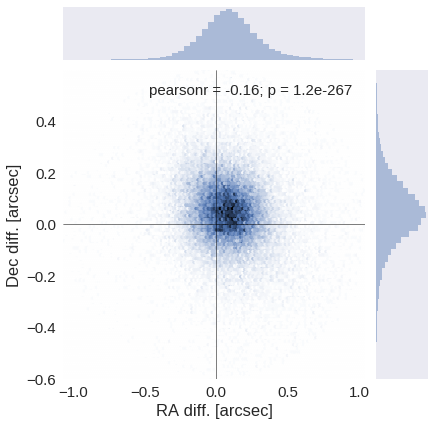

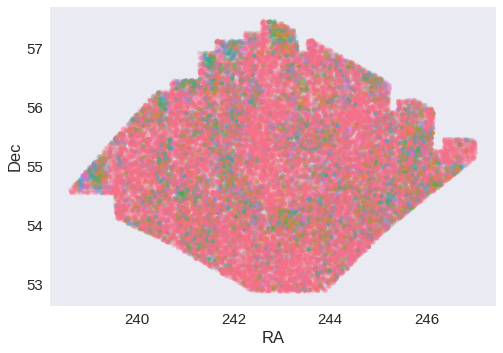

In [19]:
nb_astcor_diag_plot(wfc['wfc_ra'], wfc['wfc_dec'], gaia_coords.ra, gaia_coords.dec)

In [20]:
wfc_delta_ra, wfc_delta_dec = astrometric_correction(
    SkyCoord(wfc['wfc_ra'], wfc['wfc_dec']),
    gaia_coords
)
wfc['wfc_ra'] += wfc_delta_ra
wfc['wfc_dec'] += wfc_delta_dec

print("WFC delta RA / delta Dec: {} / {}".format(wfc_delta_ra, wfc_delta_dec))

WFC delta RA / delta Dec: 0.0 arcsec / 0.0 arcsec


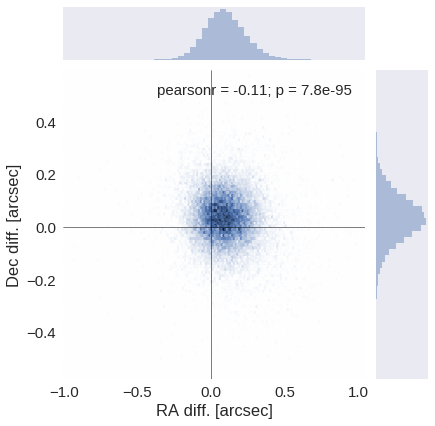

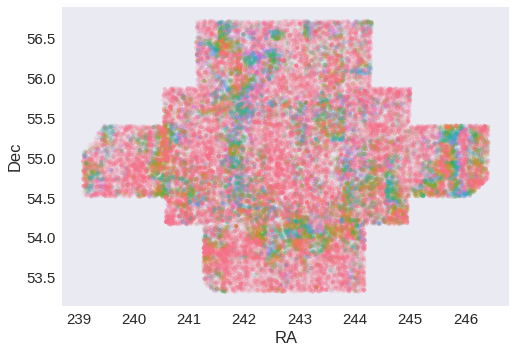

In [21]:
nb_astcor_diag_plot(dxs['dxs_ra'], dxs['dxs_dec'], gaia_coords.ra, gaia_coords.dec)

In [22]:
dxs_delta_ra, dxs_delta_dec = astrometric_correction(
    SkyCoord(dxs['dxs_ra'], dxs['dxs_dec']),
    gaia_coords
)
dxs['dxs_ra'] += dxs_delta_ra
dxs['dxs_dec'] += dxs_delta_dec

print("DXS delta RA / delta Dec: {} / {}".format(dxs_delta_ra, dxs_delta_dec))

DXS delta RA / delta Dec: 0.0 arcsec / 0.0 arcsec


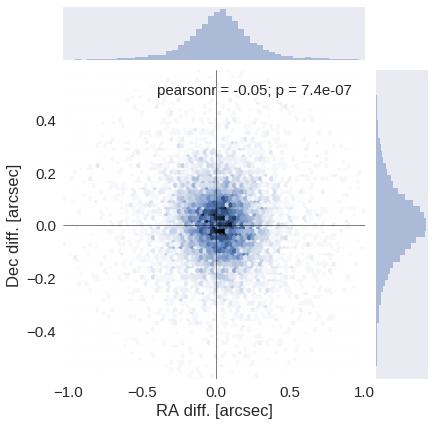

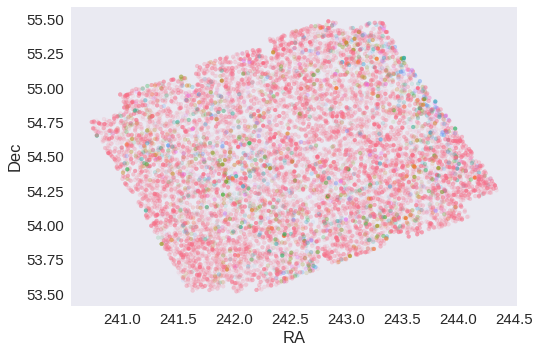

In [23]:
nb_astcor_diag_plot(servs['servs_ra'], servs['servs_dec'], gaia_coords.ra, gaia_coords.dec)

In [24]:
servs_delta_ra, servs_delta_dec = astrometric_correction(
    SkyCoord(servs['servs_ra'], servs['servs_dec']),
    gaia_coords
)
servs['servs_ra'] += servs_delta_ra
servs['servs_dec'] += servs_delta_dec

print("SERVS delta RA / delta Dec: {} / {}".format(servs_delta_ra, servs_delta_dec))

SERVS delta RA / delta Dec: 0.0 arcsec / 0.0 arcsec


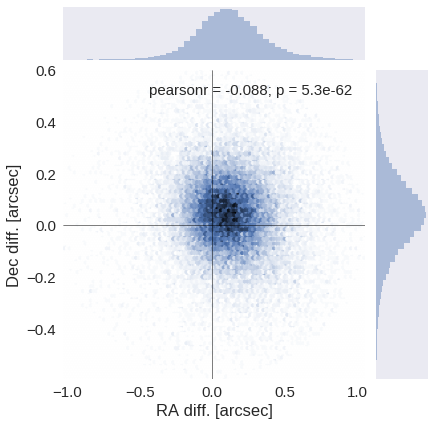

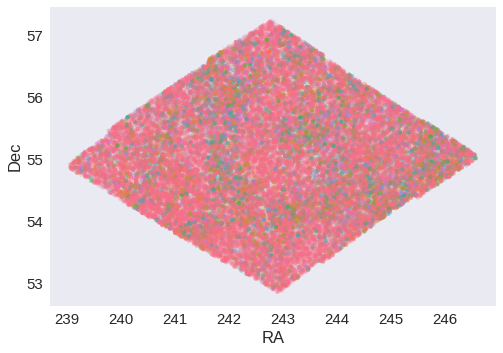

In [25]:
nb_astcor_diag_plot(swire['swire_ra'], swire['swire_dec'], gaia_coords.ra, gaia_coords.dec)

In [26]:
swire_delta_ra, swire_delta_dec = astrometric_correction(
    SkyCoord(swire['swire_ra'], swire['swire_dec']),
    gaia_coords
)
swire['swire_ra'] += swire_delta_ra
swire['swire_dec'] += swire_delta_dec

print("SWIRE delta RA / delta Dec: {} / {}".format(swire_delta_ra, swire_delta_dec))

SWIRE delta RA / delta Dec: 0.11121544077354883 arcsec / 0.0 arcsec


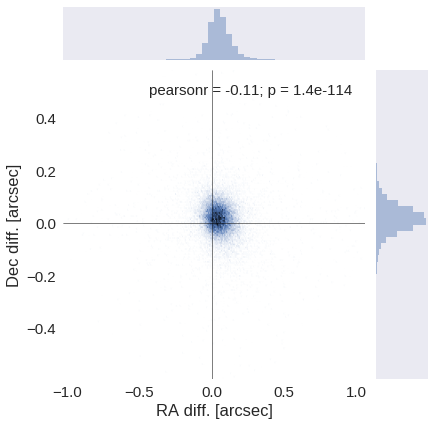

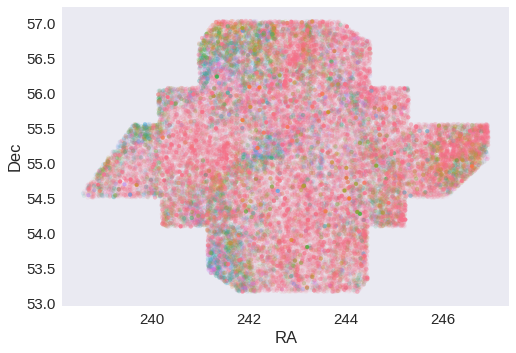

In [27]:
nb_astcor_diag_plot(sparcs['sparcs_ra'], sparcs['sparcs_dec'], gaia_coords.ra, gaia_coords.dec)

In [28]:
sparcs_delta_ra, sparcs_delta_dec = astrometric_correction(
    SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec']),
    gaia_coords
)
sparcs['sparcs_ra'] += sparcs_delta_ra
sparcs['sparcs_dec'] += sparcs_delta_dec

print("SpARCS delta RA / delta Dec: {} / {}".format(sparcs_delta_ra, sparcs_delta_dec))

SpARCS delta RA / delta Dec: 0.0 arcsec / 0.0 arcsec


## IV - Flagging Gaia objects

In [29]:
wfc.add_column(
    gaia_flag_column(
        SkyCoord(wfc['wfc_ra'], wfc['wfc_dec']),
        wfc_epoch,
        gaia
    )
)
wfc['flag_gaia'].name = 'wfc_flag_gaia'
print("{} sources flagged.".format(np.sum(wfc['wfc_flag_gaia'] > 0)))

52550 sources flagged.


In [30]:
dxs.add_column(
    gaia_flag_column(
        SkyCoord(dxs['dxs_ra'], dxs['dxs_dec']),
        dxs_epoch,
        gaia
    )
)
dxs['flag_gaia'].name = 'dxs_flag_gaia'
print("{} sources flagged.".format(np.sum(dxs['dxs_flag_gaia'] > 0)))

35062 sources flagged.


In [31]:
servs.add_column(
    gaia_flag_column(
        SkyCoord(servs['servs_ra'], servs['servs_dec']),
        servs_epoch,
        gaia
    )
)
servs['flag_gaia'].name = 'servs_flag_gaia'
print("{} sources flagged.".format(np.sum(servs['servs_flag_gaia'] > 0)))

10149 sources flagged.


In [32]:
swire.add_column(
    gaia_flag_column(
        SkyCoord(swire['swire_ra'], swire['swire_dec']),
        swire_epoch,
        gaia
    )
)
swire['flag_gaia'].name = 'swire_flag_gaia'
print("{} sources flagged.".format(np.sum(swire['swire_flag_gaia'] > 0)))

2164 sources flagged.


In [33]:
sparcs.add_column(
    gaia_flag_column(
        SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec']),
        sparcs_epoch,
        gaia
    )
)
sparcs['flag_gaia'].name = 'sparcs_flag_gaia'
print("{} sources flagged.".format(np.sum(sparcs['sparcs_flag_gaia'] > 0)))

43243 sources flagged.


## IV - Flagging objects near bright stars

## V- Merging the catalogues

In [34]:
wfc['wfc_ra'].name = 'ra'
wfc['wfc_dec'].name = 'dec'
masterlist_catalogue = merge_catalogues(wfc, dxs, "dxs_ra", "dxs_dec")
masterlist_catalogue = merge_catalogues(masterlist_catalogue, servs, "servs_ra", "servs_dec")
masterlist_catalogue = merge_catalogues(masterlist_catalogue, swire, "swire_ra", "swire_dec")
masterlist_catalogue = merge_catalogues(masterlist_catalogue, sparcs, "sparcs_ra", "sparcs_dec")

In [35]:
# When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes
# only from a catalogue and has no counterparts in the other, the columns from the latest
# are masked for that row). We indicate to use NaN for masked values for floats columns and
# False for flag columns.
for col in masterlist_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        masterlist_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        masterlist_catalogue[col].fill_value = False

In [36]:
masterlist_catalogue[:10].show_in_notebook()

idx,wfc_id,ra,dec,wfc_stellarity,m_app_wfc_u,merr_app_wfc_u,m_wfc_u,merr_wfc_u,m_app_wfc_g,merr_app_wfc_g,m_wfc_g,merr_wfc_g,m_app_wfc_r,merr_app_wfc_r,m_wfc_r,merr_wfc_r,m_app_wfc_i,merr_app_wfc_i,m_wfc_i,merr_wfc_i,m_app_wfc_z,merr_app_wfc_z,m_wfc_z,merr_wfc_z,f_app_wfc_u,ferr_app_wfc_u,flag_app_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_app_wfc_g,ferr_app_wfc_g,flag_app_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_app_wfc_r,ferr_app_wfc_r,flag_app_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_app_wfc_i,ferr_app_wfc_i,flag_app_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_app_wfc_z,ferr_app_wfc_z,flag_app_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z,wfc_flag_cleaned,wfc_flag_gaia,flag_merged,dxs_id,dxs_stellarity,m_app_ukidss_j,merr_app_ukidss_j,m_ukidss_j,merr_ukidss_j,m_app_ukidss_h,merr_app_ukidss_h,m_ukidss_h,merr_ukidss_h,m_app_ukidss_k,merr_app_ukidss_k,m_ukidss_k,merr_ukidss_k,f_app_ukidss_j,ferr_app_ukidss_j,flag_app_ukidss_j,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_app_ukidss_h,ferr_app_ukidss_h,flag_app_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_app_ukidss_k,ferr_app_ukidss_k,flag_app_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,dxs_flag_cleaned,dxs_flag_gaia,servs_intid,f_app_servs_irac1,ferr_app_servs_irac1,f_servs_irac1,ferr_servs_irac1,servs_stellarity_irac1,f_app_servs_irac2,ferr_app_servs_irac2,f_servs_irac2,ferr_servs_irac2,servs_stellarity_irac2,m_app_servs_irac1,merr_app_servs_irac1,flag_app_servs_irac1,m_servs_irac1,merr_servs_irac1,flag_servs_irac1,m_app_servs_irac2,merr_app_servs_irac2,flag_app_servs_irac2,m_servs_irac2,merr_servs_irac2,flag_servs_irac2,servs_flag_cleaned,servs_flag_gaia,swire_intid,f_app_swire_irac1,ferr_app_swire_irac1,f_swire_irac1,ferr_swire_irac1,swire_stellarity_irac1,f_app_swire_irac2,ferr_app_swire_irac2,f_swire_irac2,ferr_swire_irac2,swire_stellarity_irac2,f_app_swire_irac3,ferr_app_swire_irac3,f_swire_irac3,ferr_swire_irac3,swire_stellarity_irac3,f_app_swire_irac4,ferr_app_swire_irac4,f_swire_irac4,ferr_swire_irac4,swire_stellarity_irac4,m_app_swire_irac1,merr_app_swire_irac1,flag_app_swire_irac1,m_swire_irac1,merr_swire_irac1,flag_swire_irac1,m_app_swire_irac2,merr_app_swire_irac2,flag_app_swire_irac2,m_swire_irac2,merr_swire_irac2,flag_swire_irac2,m_app_swire_irac3,merr_app_swire_irac3,flag_app_swire_irac3,m_swire_irac3,merr_swire_irac3,flag_swire_irac3,m_app_swire_irac4,merr_app_swire_irac4,flag_app_swire_irac4,m_swire_irac4,merr_swire_irac4,flag_swire_irac4,swire_flag_cleaned,swire_flag_gaia,sparcs_intid,sparcs_stellarity,m_app_cfht_megacam_u,merr_app_cfht_megacam_u,f_app_cfht_megacam_u,ferr_app_cfht_megacam_u,m_cfht_megacam_u,merr_cfht_megacam_u,f_cfht_megacam_u,ferr_cfht_megacam_u,flag_cfht_megacam_u,m_app_cfht_megacam_g,merr_app_cfht_megacam_g,f_app_cfht_megacam_g,ferr_app_cfht_megacam_g,m_cfht_megacam_g,merr_cfht_megacam_g,f_cfht_megacam_g,ferr_cfht_megacam_g,flag_cfht_megacam_g,m_app_cfht_megacam_r,merr_app_cfht_megacam_r,f_app_cfht_megacam_r,ferr_app_cfht_megacam_r,m_cfht_megacam_r,merr_cfht_megacam_r,f_cfht_megacam_r,ferr_cfht_megacam_r,flag_cfht_megacam_r,m_app_cfht_megacam_z,merr_app_cfht_megacam_z,f_app_cfht_megacam_z,ferr_app_cfht_megacam_z,m_cfht_megacam_z,merr_cfht_megacam_z,f_cfht_megacam_z,ferr_cfht_megacam_z,flag_cfht_megacam_z,sparcs_flag_cleaned,sparcs_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,
0,614822400586,245.941736824,55.911322389,0.999999,0.0,0.0,24.334,0.195,21.002,0.033,21.108,0.034,20.043,0.024,20.149,0.025,19.609,0.03,19.699,0.031,19.47,0.047,19.616,0.052,3.63078e+09,0.0,False,0.670502,0.120423,False,14.4278,0.43852,False,13.0858,0.409783,False,34.898,0.771413,False,31.6519,0.728812,False,52.0475,1.43813,False,47.9071,1.36785,False,59.1562,2.56079,False,51.7131,2.47673300328,False,False,3,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False,--,--,False,--,--,False,--,

## VI - Merging flags and stellarity

In [37]:
masterlist_catalogue.add_column(Column(
    data=(masterlist_catalogue['wfc_flag_cleaned'] | 
          masterlist_catalogue['dxs_flag_cleaned'] |
          masterlist_catalogue['servs_flag_cleaned'] | 
          masterlist_catalogue['swire_flag_cleaned'] |
          masterlist_catalogue['sparcs_flag_cleaned']),
    name="flag_cleaned"
))
masterlist_catalogue.remove_columns(['wfc_flag_cleaned', 'dxs_flag_cleaned',
                                     'servs_flag_cleaned', 'swire_flag_cleaned',
                                     'sparcs_flag_cleaned'])

In [38]:
masterlist_catalogue.add_column(Column(
    data=(masterlist_catalogue['wfc_flag_gaia'] | 
          masterlist_catalogue['dxs_flag_gaia'] |
          masterlist_catalogue['servs_flag_gaia'] | 
          masterlist_catalogue['swire_flag_gaia'] |
          masterlist_catalogue['sparcs_flag_gaia']),
    name="flag_gaia"
))
masterlist_catalogue.remove_columns(['wfc_flag_gaia', 'dxs_flag_gaia',
                                     'servs_flag_gaia', 'swire_flag_gaia',
                                     'sparcs_flag_gaia'])

In [39]:
masterlist_catalogue.add_column(Column(
    data=np.nanmean([masterlist_catalogue['wfc_stellarity'],
                     masterlist_catalogue['dxs_stellarity'],
                     masterlist_catalogue['servs_stellarity_irac1'],
                     masterlist_catalogue['servs_stellarity_irac2'],
                     masterlist_catalogue['swire_stellarity_irac1'],
                     masterlist_catalogue['swire_stellarity_irac2'],
                     masterlist_catalogue['swire_stellarity_irac3'],
                     masterlist_catalogue['swire_stellarity_irac4'],
                     masterlist_catalogue['sparcs_stellarity']],
                   axis=0),
    name='stellarity'
))
masterlist_catalogue.remove_columns(
    ['wfc_stellarity',
     'dxs_stellarity',
     'servs_stellarity_irac1',
     'servs_stellarity_irac2',
     'swire_stellarity_irac1',
     'swire_stellarity_irac2',
     'swire_stellarity_irac3',
     'swire_stellarity_irac4',
     'sparcs_stellarity']
)

## VII - E(B-V)

In [40]:
masterlist_catalogue.add_column(
    ebv(masterlist_catalogue['ra'], masterlist_catalogue['dec'])
)

## VIII - Choosing between multiple values for the same filter

We have IRAC1 and IRAC2 observation for both SERVS and SWIRE.  We must choose which one to use, remove the unused columns, and rename the ones we keep to names like `f_irac1`...

## IX - Number of bands with observation

In [41]:
nb_bands = np.zeros(len(masterlist_catalogue), dtype=int)
for col in masterlist_catalogue.colnames:
    if 'm_app_' in col:
        masterlist_catalogue[col].fill_value = np.nan
        nb_bands += (~np.isnan(masterlist_catalogue[col].filled()))

masterlist_catalogue.add_column(Column(data=nb_bands, name="nb_optnir_bands"))

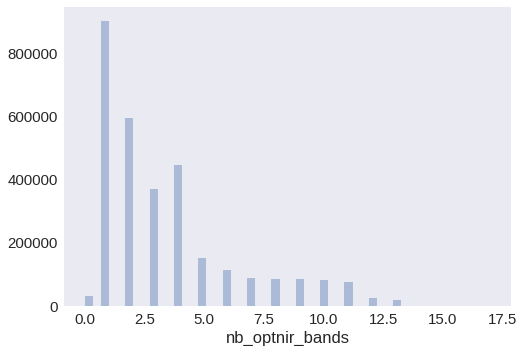

In [42]:
sns.distplot(masterlist_catalogue['nb_optnir_bands'], kde=False)

## X - Adding the HELP Id and field columns

In [43]:
masterlist_catalogue.add_column(Column(
    gen_help_id(masterlist_catalogue['ra'], masterlist_catalogue['dec']),
    name="help_id"
))
masterlist_catalogue.add_column(Column(
    np.full(len(masterlist_catalogue), "ELAIS-N1", dtype='<U18'),
    name="field"
))

In [44]:
# Check that the HELP Ids are unique
if len(masterlist_catalogue) != len(np.unique(masterlist_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## XI - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [45]:
cross_ident_table = masterlist_catalogue[
    'help_id', 'wfc_id', 'dxs_id', 'servs_intid', 'swire_intid', 'sparcs_intid']
cross_ident_table.write("master_list_cross_ident_elais-n1.fits", overwrite=True)

## XII - Cleaning an saving the master catalogue

In [46]:
masterlist_catalogue.remove_columns([
    'wfc_id', 'dxs_id', 'servs_intid', 'swire_intid', 'sparcs_intid'])

In [47]:
# We may want to reorder the column even if this will be done at the ingestion in HeDaM.

In [48]:
masterlist_catalogue.write("master_catalogue_elais-n1.fits", overwrite=True)